# MOIRAI

[MOIRAI](https://arxiv.org/pdf/2402.02592) aims to be a unified training for U Time series forecasting.

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from gluonts.dataset.repository import dataset_recipes


from gluonts.dataset.split import split
import numpy as np
import torch
from einops import rearrange
from uni2ts.eval_util.data import get_gluonts_test_dataset
from uni2ts.eval_util.plot import plot_single, plot_next_multi
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

/home/mdenolle/GeoCAST/src/uni2ts/src/uni2ts/common/env.py:43: UserWarning: Failed to load .env file.
  warnings.warn("Failed to load .env file.")


In [ ]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()

import matplotlib.pyplot as plt
import torch
from chronos import ChronosPipeline
import pandas as pd
import numpy as np


# Set the font style and size
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'sans-serif',
    'font.serif': ['DejaVu Sans'],
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10
})

### Settings
SIZE: model size, select the model size of Moirai to perform inference with

CTX: context length, how many time steps the model will take as input for inference

PSZ: patch size, how many time steps to perform patching with

BSZ: batch size, number of samples in each batch for inference

In [77]:
SIZE = "large"  # model size: choose from {'small', 'base', 'large'}
CTX = 1000  # context length: any positive integer
PDT = 64  # prediction length: any positive integer
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32  # batch size: any positive integer
TEST = 100
n_timeseries = BSZ

In [78]:
# Prepare model
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-{SIZE}"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size="auto",
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)

In [4]:
def reshape_time_series(df, name_of_target="count" ,n_timeseries=20, duration_years=2):
    """
    Generate a list of time series from the given DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing a 'datetime' column.
    n_timeseries (int): Number of time series to generate.
    duration_years (int): Duration of each time series in years.
    resample_period (str): Resampling period (e.g., 'D' for daily).

    Returns:
    list: A list of DataFrames, each containing a time series.
    pd.DataFrame: A wide-format DataFrame containing the time series.
    """
    df_list = [pd.DataFrame() for _ in range(n_timeseries)]
    kk = 0
    while kk < n_timeseries:
        start_date = df["datetime"].sample().values[0]
        start_date = pd.to_datetime(start_date)
        # Create a time series for the specified duration
        end_date = start_date + pd.DateOffset(years=duration_years)
        if end_date > df["datetime"].max():
            continue    # Skip if the end date exceeds the maximum date in the catalog
        # Create a time series from the catalog and select only the date time and target columns
        time_series = df[(df["datetime"] >= start_date) & (df["datetime"] <= end_date)][["datetime", name_of_target]]
        time_series = time_series.set_index("datetime")
        # time_series = time_series.resample(resample_period).mean().interpolate() # resample and interpolate
        time_series = time_series.ffill()#(method="ffill") # forward fill
        time_series = time_series.bfill()#(method="bfill") # backward fill
        time_series = time_series.reset_index()# reset index to keep datetime as a column
        # remove the "datetime" column to the time_series
        
        df_list[kk] = time_series
        kk += 1 
    df_list_count = [pd.DataFrame() for _ in range(n_timeseries)]
    for ik in range(n_timeseries):
        df_list_count[ik] = df_list[ik][name_of_target]
        df_list_count[ik] = df_list_count[ik].rename(f"target_{ik}")
    df_wide = pd.concat(df_list_count, axis=1)

    # find the sampling rate dt as the difference between the first two dates
    dt = df["datetime"].diff().dt.total_seconds().fillna(0).mean()
    # convert dt to days
    dt = dt / (24 * 3600)
    print("sampling rate {:.2f} days".format(dt))

    # create a time array that is the index of the time series and convert the dae
    df_wide["time_index"] = np.arange(len(df_wide)) #* pd.Timedelta(days=dt)
    # move the last column to the first position
    cols = df_wide.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df_wide = df_wide[cols]

    # rename columns to target_ID except for the first column that is a datetime
    df_wide.columns = [f"target_{i}" if i != 0 else "time_index" for i in range(len(df_wide.columns))]
    df_wide = df_wide.dropna() 
    
    return df_list, df_wide

# Example usage:
# df_list,df_wide = reshape_time_series(df, n_timeseries=20, duration_years=2, resample_period='D')

In [ ]:
def predict_moirai(df, predict_length=64, n_timeseries=20):
    """
    Make predictions for the given time series data.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the time series data.

    Returns:
    forecast_mean (np.array): The mean forecasted values for the time series.
    lower_bound (np.array): The 5% lower bound of the forecasted values.
    upper_bound (np.array): The 95% upper bound of the forecasted values.
    mean_mae (float): The mean absolute error of the forecasted values.
    no_var_mae (float): The mean absolute error assuming no change in the time series.


    """
    # Ensure df['Date'] is in datetime format
    # df['datetime'] = pd.to_datetime(df['datetime'])

    # # Select the first n_timeseries columns for forecasting
    # columns_to_forecast = df.columns[1:n_timeseries+1]  # +1 to skip the 'Date' column

    # # Calculate the split index for training
    # split_index = int(len(df) - predict_length)

    # # Split the data into training and evaluation sets for all selected columns
    # train_data = df[columns_to_forecast].iloc[:split_index]
    # eval_data = df[columns_to_forecast].iloc[split_index:]

    # # Convert the training data to a higher-dimensional tensor
    # train_tensor = torch.tensor(train_data.values, dtype=torch.float32).T
    # # Perform the forecasting using the training data
    # forecast = pipeline.predict(
    #     context=train_tensor,
    #     prediction_length=len(eval_data),  # Predict the same length as the evaluation set
    #     num_samples=50,
    # )

    # # Take the mean across the samples (axis=1) for each time series
    # forecast_mean = forecast.mean(dim=1).squeeze().numpy()
    # lower_bound = forecast.quantile(0.05, dim=1).squeeze().numpy()
    # upper_bound = forecast.quantile(0.95, dim=1).squeeze().numpy()


    mae=[]
    # Calculate and print the MAE for each time series
    for i, column_name in enumerate(columns_to_forecast):
        # Calculate MAE for the current time series
        mae.append (np.mean(np.abs(forecast_mean[i]- eval_data[column_name].values)))
        
        # Print the MAE
        print(f'Mean Absolute Error (MAE) for {column_name}: {mae[-1]}')

    mean_mae = np.array(mae).mean()
    print(f'Mean of forecast MAEs = {mean_mae}')

    # Calculate and print the MASE for each time series
    mase=[]
    for i, column_name in enumerate(columns_to_forecast):
        # Calculate MASE for the current time series
        mase.append (np.mean(np.abs(forecast_mean[i] - eval_data[column_name].values)) / np.mean(np.abs(eval_data[column_name].values[1:] - eval_data[column_name].values[:-1])))
        
        # Print the MASE
        print(f'Mean Absolute Scaled Error (MASE) for {column_name}: {mase[-1]}')

    mean_mase = np.array(mase).mean()
    print(f'Mean of forecast MAEs = {mean_mase}')


    # Baseline model: Assume no change in the time series
    mae_nochangemodel=[]
    # Calculate and print the MAE for each time series
    for i, column_name in enumerate(columns_to_forecast):
        # Calculate MAE for the current time series
        mae_nochangemodel.append (np.mean(np.abs(eval_data[column_name].values[-1] - eval_data[column_name].values)))
        
        # Print the MAE
        # print(f'MAE assuming d/dt=0 for {column_name}: {mae_nochangemodel[-1]}')

    no_var_mae = np.array(mae_nochangemodel).mean()
    print(f'Mean of d/dt=0 MAEs = {no_var_mae}')

    return forecast,mean_mae, mean_mase, no_var_mae, split_index

In [5]:
def plot_forecasts(df_wide,split_index,forecast,n_timeseries,field="count",filename="geo-forecast.png"):
    """
    Plot the forecasted values along with the confidence intervals.

    Parameters:
    n_timeseries (int): Number of time series to plot.
    df_wide (pd.DataFrame): The wide-format DataFrame containing the time series.
    split_index (int): The index at which the training data ends (or context data) and evaluation (or forecast) data begins.
    forecast (np.array): The forecasted values for the time series.
    filename (str): The filename to save the plot.


    Returns:
    None


    """
    
    # Determine the number of rows and columns for the subplots
    n_timeseries = min(n_timeseries, 12)  # Cap the number of time series to 12
    nrows = (n_timeseries - 1) // 3 + 1
    ncols = min(n_timeseries, 3)

    # Select the first n_timeseries columns for forecasting
    columns_to_forecast = df_wide.columns[1:n_timeseries+1]  # +1 to skip the 'Date' column
    print(forecast.shape)
    forecast_mean = forecast.mean(dim=1).squeeze()
    print(forecast_mean.shape)
    lower_bound = np.percentile(forecast, 5, axis=0)
    upper_bound = np.percentile(forecast, 95, axis=0)

    # Layout the subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 16), sharex=True)
    # Flatten the 2D array of axes for easy indexing
    if n_timeseries>1:
        axes = axes.flatten()
    else:
        axes = [axes]
        


    # Split the data into training and evaluation sets for all selected columns
    # train_data = df_wide[columns_to_forecast].iloc[:split_index]
    eval_data = df_wide[columns_to_forecast].iloc[split_index:]


    # Calculate and print the MASE for each time series
    mase=[]
    for i, column_name in enumerate(columns_to_forecast):
        # Calculate MASE for the current time series
        mase.append (np.mean(np.abs(forecast_mean[i].numpy()  - eval_data[column_name].values)) / np.mean(np.abs(eval_data[column_name].values[1:] - eval_data[column_name].values[:-1])))
        
    mean_mase = np.array(mase).mean()
    print(f'Mean of forecast MASEs = {mean_mase}')
    print(n_timeseries)
    # Iterate over the first n_timeseries and plot
    if n_timeseries>1:
        for i, column_name in enumerate(columns_to_forecast[0:n_timeseries]):
            # Plot the original data
            axes[i].plot(df_wide['time_index'], df_wide[column_name], label='Original Data')
            
            # Calculate the 5th and 95th percentiles for the confidence interval
            lower_bound = np.percentile(forecast[i, :, :], 5, axis=0)
            upper_bound = np.percentile(forecast[i, :, :], 95, axis=0)
            
            # Plot the forecast
            axes[i].plot(df_wide['time_index'].iloc[split_index:], forecast_mean[i], label='Forecast')
            
            # Plot the confidence intervals
            axes[i].fill_between(df_wide['time_index'].iloc[split_index:], lower_bound, upper_bound, 
                                color='r', alpha=0.2, label='95% CI')


            # set the x-axis labels as the number of days
            # axes[i].set_xticks(np.arange(0,len(df_wide['datetime']), step=30))
            axes[i].grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, color='gray')

            # Plot the evaluation data for reference
            # axes[i].plot(df_wide['datetime'].iloc[split_index:], eval_data[column_name].values, '--', label='Evaluation Data')

            # Format the subplot
            axes[i].set_title(f'{field} {i} , MASE={mase[i]:.2f}')
            axes[i].set_ylabel(field)
            axes[i].set_xlabel('Time Index')
            if i==0: axes[i].legend()

            # Apply x-tick rotation
            # axes[i].xaxis.set_major_locator(mdates.AutoDateLocator())
            # axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            axes[i].tick_params(axis='x', rotation=45)
            # axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            # convert the x-labels to days every month
            # axes[i].xaxis.set_major_locator(plt.MaxNLocator(6))
    else:
        # Plot the original data
        axes[i].plot(df_wide['time_index'], df_wide[column_name], label='Original Data')
        
        # Calculate the 5th and 95th percentiles for the confidence interval
        lower_bound = np.percentile(forecast[i, :, :], 5, axis=0)
        upper_bound = np.percentile(forecast[ i, :, :], 95, axis=0)
        print(forecast_mean.shape)
        # Plot the forecast
        axes[i].plot(df_wide['time_index'].iloc[split_index:], forecast_mean, label='Forecast')
        
        # Plot the confidence intervals
        axes[i].fill_between(df_wide['time_index'].iloc[split_index:], lower_bound, upper_bound, 
                            color='r', alpha=0.2, label='95% CI')


        # set the x-axis labels as the number of days
        # axes[i].set_xticks(np.arange(0,len(df_wide['datetime']), step=30))
        axes[i].grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, color='gray')

        # Plot the evaluation data for reference
        # axes[i].plot(df_wide['datetime'].iloc[split_index:], eval_data[column_name].values, '--', label='Evaluation Data')

        # Format the subplot
        axes[i].set_title(f'{field} {i} , MASE={mase[i]:.2f}')
        axes[i].set_ylabel(field)
        axes[i].set_xlabel('Time Index')
        if i==0: axes[i].legend()

        # Apply x-tick rotation
        # axes[i].xaxis.set_major_locator(mdates.AutoDateLocator())
        # axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        axes[i].tick_params(axis='x', rotation=45)




    # Remove empty subplots if n_timeseries < 8
    for j in range(i + 1, nrows * ncols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig(filename)
    # also save a SVG 
    plt.savefig(filename.replace('.png','.svg'))
    plt.show()


    # add a column to df_wide with the predictions for each target_{i} labels at the rows of the evaluation data
    for i, column_name in enumerate(columns_to_forecast):
        df_wide.loc[df_wide.index[split_index:], f'forecast_{i}'] = forecast_mean[i].numpy()

    # store the new df_wide with the precition into a new CSV files that takes the filename of the original file
    df_wide.to_csv(filename.replace('.png','.csv'), index=False)

    return

## 1. Earthquake Catalogs



In [38]:
# first we load data/data_qtm_catalog.csv
df = pd.read_csv("../data/data_qtm_catalog.csv")

In [39]:
# calculate the time difference between each datetime to set up the dt
# convert the datetime column to datetime object
df["datetime"] = pd.to_datetime(df["datetime"])
dt = df["datetime"].diff().dt.total_seconds().fillna(0).mean()
# convert seconds to days
dt = np.ceil(dt / (60 * 60 * 24))


# rename the count column to target
df = df.set_index("datetime")
df = df.rename(columns={"count":"target"})
# add a colum of item_id is all As
df["item_id"] = "A"
df.describe()

1.0


,target
count,3653.000000
mean,245.988776
std,256.838501
min,25.000000
25%,162.000000
50%,200.000000
75%,251.000000
max,4841.000000


In [ ]:
# Prepare model
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-{SIZE}"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size="auto",
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)

In [76]:
# inp = {
#     "target": df["target"].to_numpy()[:168],  # 168 = 24 * 7
#     "start": df.index[0].to_period(freq="D"),
# }
# label = {
#     "target": df["target"].to_numpy()[168:216],  # 48 = 24 * 2
#     "start": df.index[168].to_period(freq="D"),
# }

# # Time series values. Shape: (batch, time, variate)
# past_target = rearrange(
#     torch.as_tensor(inp["target"], dtype=torch.float32), "t -> 1 t 1"
# )
# # 1s if the value is observed, 0s otherwise. Shape: (batch, time, variate)
# past_observed_target = torch.ones_like(past_target, dtype=torch.bool)
# # 1s if the value is padding, 0s otherwise. Shape: (batch, time)
# past_is_pad = torch.zeros_like(past_target, dtype=torch.bool).squeeze(-1)

# forecast = model(
#     past_target=past_target,
#     past_observed_target=past_observed_target,
#     past_is_pad=past_is_pad,
# )

In [82]:
# Convert into GluonTS dataset
ds = PandasDataset.from_long_dataframe(df, target="target", item_id="item_id")

# Split into train/test set
train, test_template = split(
    ds, offset=-TEST
)  # assign last TEST time steps as test set
print(TEST//PDT)
print(TEST, PDT)

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)


1
100 64


In [88]:

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input) # iterator for input data
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

In [84]:
# for i in range(1):
#     input_data = next(input_it)
#     print(input_data["target"].shape)

(3553,)


{'start': Period('2008-01-01', 'D'), 'target': array([120,  89, 146, ..., 285, 263, 269]), 'item_id': 'A'}
{'start': Period('2017-09-23', 'D'), 'target': array([316, 277, 329, 338, 374, 329, 383, 325, 315, 322, 484, 311, 333,
       270, 312, 255, 344, 479, 375, 356, 338, 328, 256, 238, 369, 420,
       410, 281, 331, 409, 336, 235, 311, 303, 294, 280, 257, 271, 265,
       354, 332, 295, 210, 223, 318, 301, 330, 349, 394, 261, 260, 260,
       293, 264, 293, 305, 236, 344, 290, 337, 300, 296, 246, 260]), 'item_id': 'A'}


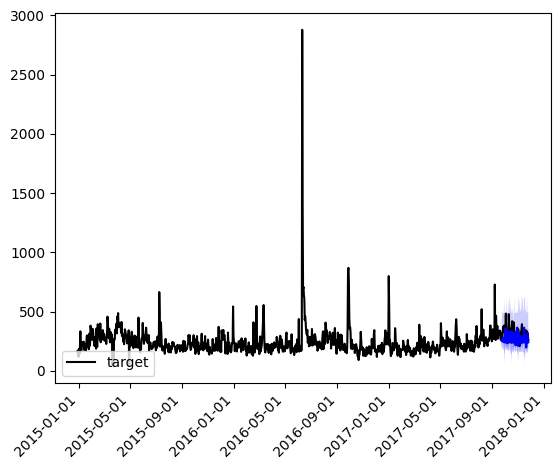

In [89]:
for ax, inp, label, forecast in zip(axes, input_it, label_it, forecast_it):
        print(inp)
        print(label)
        plot_single(
            inp,
            label,
            forecast,
            context_length=CTX,
            intervals=(0.5,0.9))
        plt.show()

In [49]:
forecast_it.plot()

AttributeError: 'generator' object has no attribute 'plot'

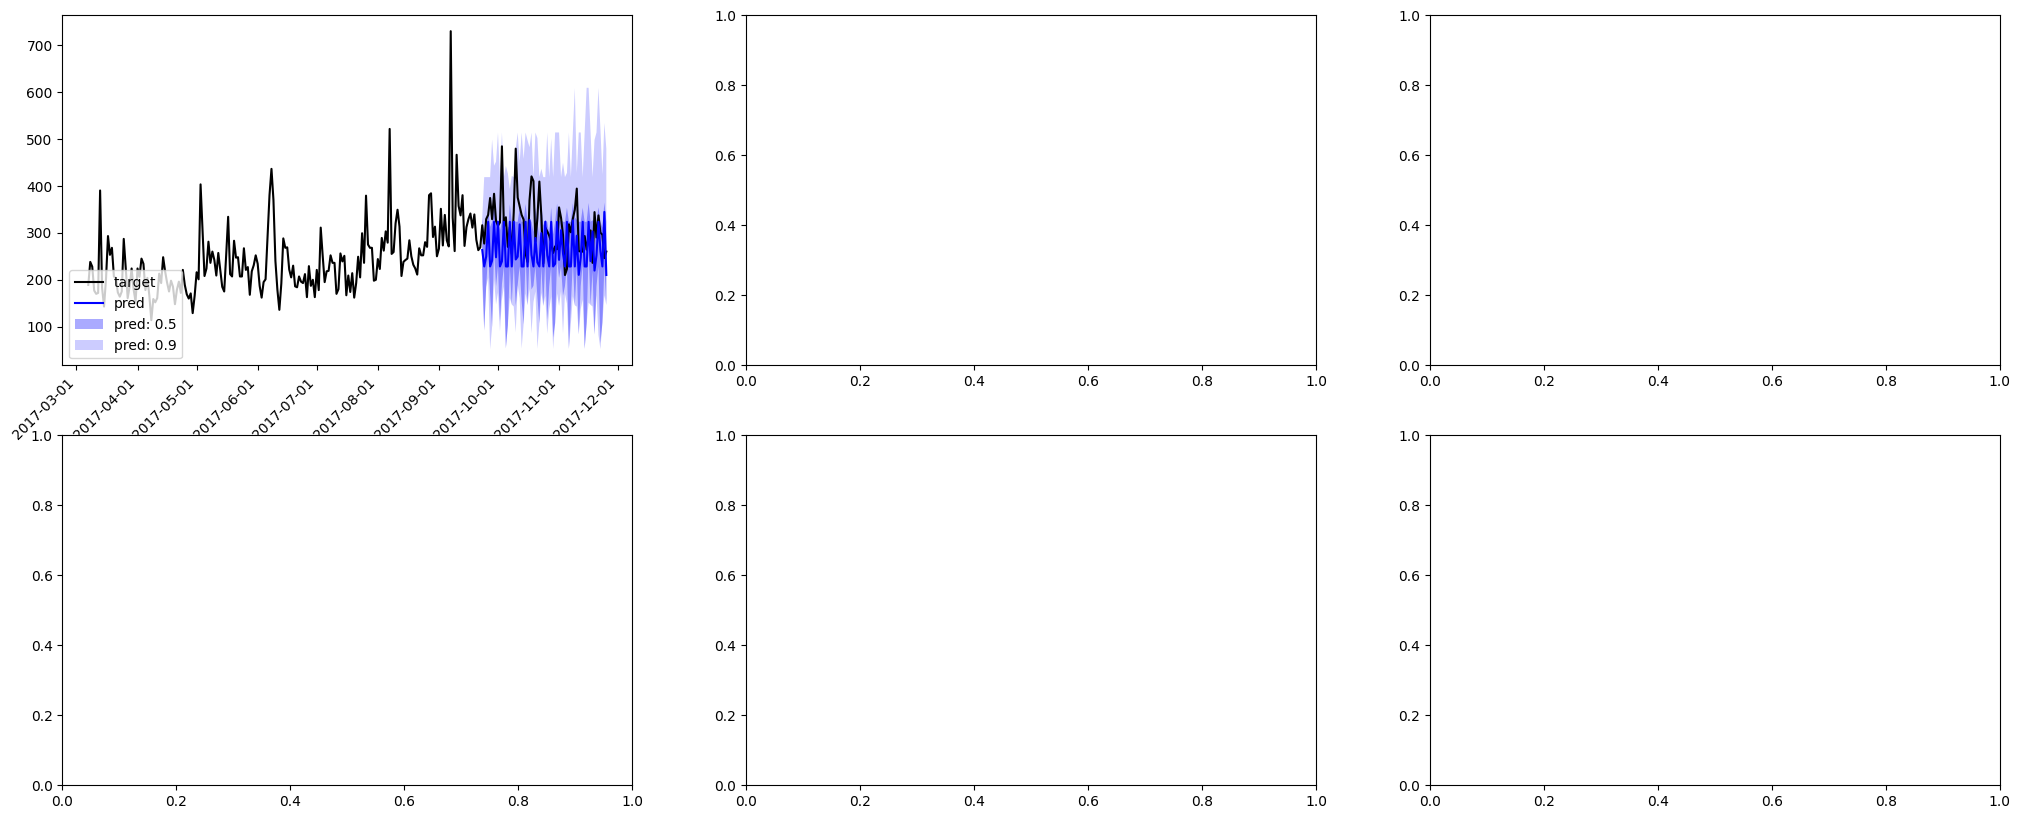

In [35]:
# Make predictions
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=200,
    intervals=(0.5, 0.9),
    dim=None,
    name="pred",
    show_label=True,
)

## Prepare for MOIRAI

In [9]:
# convert time series to torch array
data = torch.tensor(df["count"].values).float()

In [12]:
# create a sample for the daily data, using 1 year data as context window and predicting the next 2 months.
inp = {
    "target": data[0, start_date:last_date],  
    "start": start_date,
}
label = {
    "target": data[0,last_date:last_date+prediction_length], 
    "start": last_date,
}

In [58]:
# Prepare model
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-small"),
    prediction_length=prediction_length,
    context_length=CTX,
    patch_size="auto",
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)

# Time series values. Shape: (batch, time, variate)
past_target = rearrange(
    torch.as_tensor(inp["target"], dtype=torch.float32), "t -> 1 t 1" # 1 batch, t time, 1 variate
)
# 1s if the value is observed, 0s otherwise. Shape: (batch, time, variate)
past_observed_target = torch.ones_like(past_target, dtype=torch.bool)
# 1s if the value is padding, 0s otherwise. Shape: (batch, time)
past_is_pad = torch.zeros_like(past_target, dtype=torch.bool).squeeze(-1)


In [48]:
print("Shape of past_observed_target:", past_observed_target.shape)
print("Shape of past_is_pad:", past_is_pad.shape)

Shape of past_target: torch.Size([1, 700, 1])
Shape of past_observed_target: torch.Size([1, 700, 1])
Shape of past_is_pad: torch.Size([1, 700])


In [59]:
forecast = model(
    past_target=past_target,
    past_observed_target=past_observed_target,
    past_is_pad=past_is_pad)

RuntimeError: The size of tensor a (88) must match the size of tensor b (95) at non-singleton dimension 1

In [50]:
PRED

60

In [51]:
print(
    "median prediction:\n",
    np.round(np.median(forecast[0], axis=0), decimals=1),
)
print("ground truth:\n", label["target"])

median prediction:
 [ -978998.9  -581344.4  -820777.1 -1176112.   -990797.2  -956250.1
  -963290.9 -1174191.5 -1161021.  -1222086.2  -881256.8 -1122600.8
  -468102.8 -1086643.  -1038053.1 -1600476.4 -1118548.8 -1053508.
 -1776452.4 -1181949.  -1501653.5 -1382674.6 -1235815.   -998767.6
 -1343710.8 -1374215.   -817125.8 -1033905.8 -1593953.8 -1087976.5
 -1577775.2 -1390487.5 -1063673.  -1199524.  -1541937.4 -1127619.1
 -1318406.8 -1078823.2 -1403501.  -1366358.9  -876096.  -1447719.2
  -779486.9 -1539784.8 -1195491.2 -1205486.2 -1617281.9 -1556280.9
 -1055165.2 -1243955.5]
ground truth:
 tensor([   26936.2559,  -453052.6250,  -835105.9375, -1088777.5000,
        -1411582.3750, -1663795.6250, -1693551.2500, -1494270.2500,
        -1196284.0000,  -963077.2500,  -540632.1250,   148243.9375,
          516344.4062,   754356.5625,  1226814.7500,  1555539.6250,
         1556498.0000,  1647952.5000,  1604301.3750,  1361001.5000,
         1191737.7500,  1187537.6250,  1099060.5000,   982942.2500

In [52]:
forecast[0][0].shape

torch.Size([50])

In [56]:
CTX

368

In [46]:
last_date, last_date+prediction_length, prediction_length,PRED

(800, 850, 50, 60)

50
50


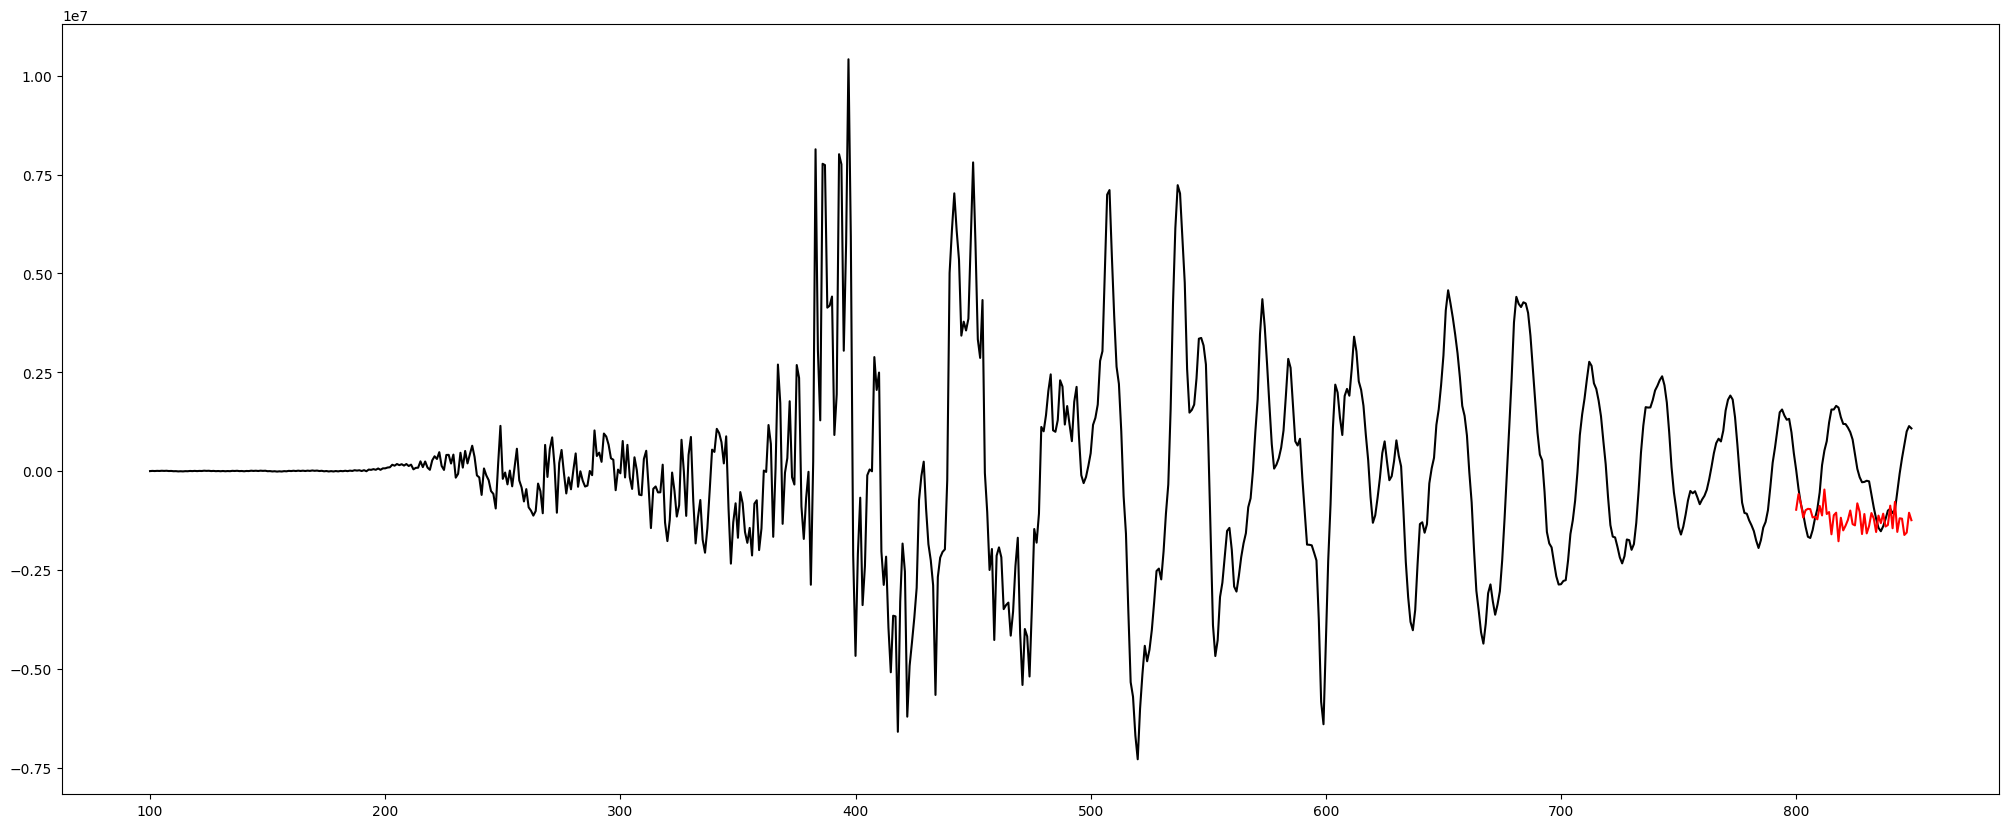

In [55]:
# now plot the input data, the ground thruth and the predictions
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25, 10))
t1 = np.arange(start_date, last_date+prediction_length)
t2 = np.arange(last_date, last_date + prediction_length)
print(len(np.median(forecast[0], axis=0)))
print(len(t2))
plt.plot(t1,data[0,start_date:last_date+prediction_length].T,'k')
plt.plot(t2,np.median(forecast[0], axis=0),'r')


## Rolling evaluation

In [ ]:
TEST = 100
PDT = PRED

In [ ]:
# Split into train/test set
train, test_template = split(
    dataset, offset=-TEST
)  # assign last TEST time steps as test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)



### Make predictions

In [ ]:
# Prepare model
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-small"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=dataset.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=dataset.num_past_feat_dynamic_real,
)

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

(0.0, 20.0)

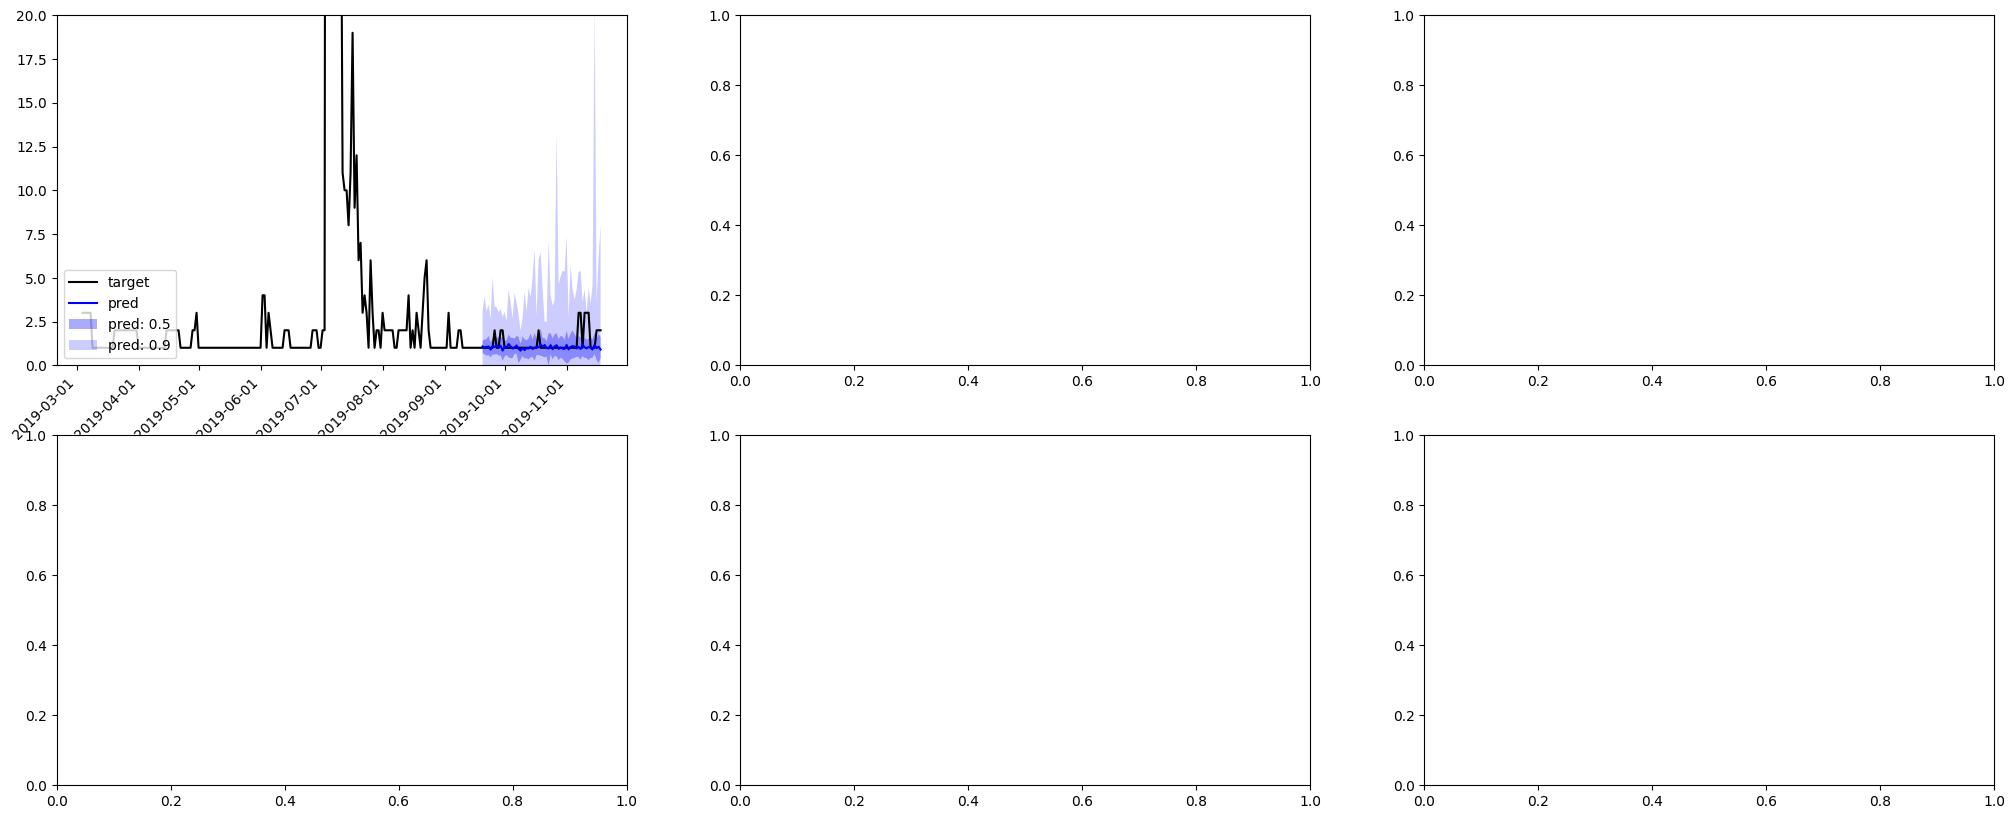

In [ ]:
# Make predictions
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=200,
    intervals=(0.5, 0.9),
    dim=None,
    name="pred",
    show_label=True,
)
axes[0,0].set_ylim([0,20])